# Pseudobulk differential expression to compare BL 2 hours vs BRZ

This notebook examines expression patterns in pseudobulk without regard to cell type or developmental stage

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex hea

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
rc.integrated <- readRDS("../data/integrations/rc.integrated_14S_BR_Li_seu3_clean.rds")

In [4]:
rc.integrated

An object of class Seurat 
71231 features across 79982 samples within 3 assays 
Active assay: integrated (17732 features, 17732 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [5]:
feature_names <- read_tsv("./data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




# Differential State Analysis with Muscat

In [6]:
# subset BRZ and BL 2 hour samples only samples you want to compare

integrated.de <- subset(rc.integrated, subset = sample %in% c("sc_2", "sc_5", "sc_43","sc_46","sc_49","sc_50"))


In [7]:
integrated.de

An object of class Seurat 
71231 features across 43748 samples within 3 assays 
Active assay: integrated (17732 features, 17732 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

In [8]:
# code control vs treated manually

integrated.de$treated <- integrated.de$time_trt %in% c("2_hour_BL")

table(integrated.de$treated)
table(integrated.de$sample)

integrated.de$treatment <- as.character(integrated.de$treated)

integrated.de$treatment<- gsub("TRUE", "BL", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)
  
integrated.de$treatment<- gsub("FALSE", "BRZ", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

integrated.de$treatment <- factor(integrated.de$treatment, levels=c("BRZ", "BL"))


table(integrated.de$treatment)


FALSE  TRUE 
21473 22275 


 sc_2 sc_43 sc_46 sc_49  sc_5 sc_50 
 7512  8874  6847  5638  9790  5087 


  BRZ    BL 
21473 22275 

## Convert to sce

In [9]:
integrated.de$all_cells <- "all" 

In [10]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample,
                              group_id = integrated.de$treatment,
                              cluster_id = integrated.de$all_cells, 
                             date=integrated.de$date)

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [11]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 28725 43748 
metadata(1): experiment_info
assays(1): counts
rownames(28725): AT1G01010 AT1G01020 ... AT4G23310 AT4G23580
rowData names(0):
colnames(43748): AAACCCAAGAGGCCAT_3 AAACCCAAGCCTGTGC_3 ...
  TTTGTTGGTGGATACG_12 TTTGTTGTCTGAGAAA_12
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [12]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 27216 43748

In [13]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 23689 43748

In [14]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "all"

In [15]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
sc_2,7521,2176,567,1125,21803,188
sc_43,5264,2906,455,1037,38643,307
sc_46,4247,2663,523,1005,47062,173
sc_49,3937,1904,440,962,32055,213
sc_5,7302,1905,486,1376,22384,198
sc_50,4304,2405,443,679,36641,341


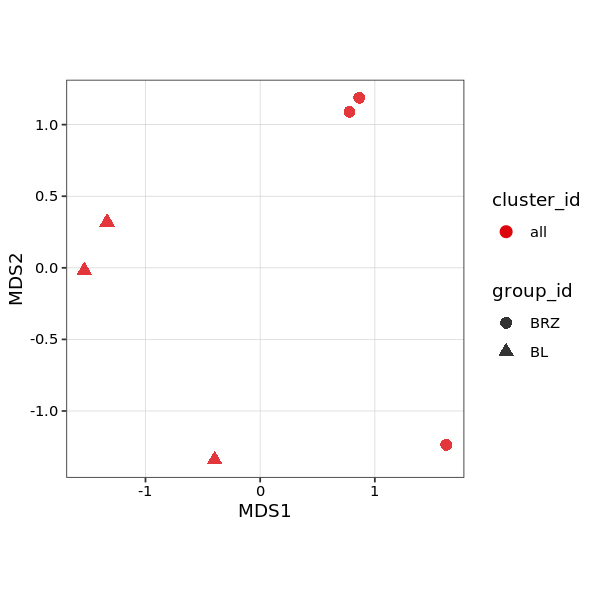

In [16]:
options(repr.plot.width=5, repr.plot.height=5)
(pb_mds <- pbMDS(pb))

In [17]:
  bscs <- read.csv("../data/Benfey_single_cell-Samples.csv", na.strings=c("","NA"), stringsAsFactors = F)
  bscs <- bscs %>% select(c('sample','name','source','genotype','transgene','treatment','age','timepoint','rep','target_cells','date','seq_run'))
  bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)
  bscs$target_cells <- prettyNum(bscs$target_cells, big.mark = ',')

In [18]:
# experiment info for contrasts, add dates from csv

ei <- metadata(sce)$experiment_info
ei

sample_date <- select(bscs, sample_id=sample, date)

ei <- left_join(ei, sample_date)

ei

sample_id,group_id,n_cells
<fct>,<fct>,<dbl>
sc_2,BRZ,7512
sc_5,BL,9790
sc_43,BRZ,8874
sc_46,BL,6847
sc_49,BL,5638
sc_50,BRZ,5087


Joining, by = "sample_id"



sample_id,group_id,n_cells,date
<chr>,<fct>,<dbl>,<chr>
sc_2,BRZ,7512,2019-12-14
sc_5,BL,9790,2019-12-14
sc_43,BRZ,8874,2020-02-12
sc_46,BL,6847,2020-02-12
sc_49,BL,5638,2020-02-12
sc_50,BRZ,5087,2020-02-12


In [19]:
mm <- model.matrix(~ 0 + ei$group_id + ei$date)
dimnames(mm) <- list(ei$sample_id, c(levels(ei$group_id), "date"))

mm

,BRZ,BL,date
sc_2,1,0,0
sc_5,0,1,0
sc_43,1,0,1
sc_46,0,1,1
sc_49,0,1,1
sc_50,1,0,1


In [20]:
contrast <- makeContrasts("BL-BRZ", levels = mm)

contrast

,BL-BRZ
BRZ,-1
BL,1
date,0


In [21]:
res <- pbDS(pb, design = mm, 
            contrast = contrast, 
            method="edgeR", 
            min_cells=5, 
            filter = c("none"))

all..

### DEG results

In [22]:
# DEG results with gene freqs
(res_to_write_frq <- resDS(sce, res, bind = "row", cpm=TRUE, frq=T))

gene,cluster_id,sc_2.cpm,sc_43.cpm,sc_50.cpm,sc_5.cpm,sc_46.cpm,sc_49.cpm,sc_2.frq,sc_43.frq,⋯,sc_49.frq,BRZ.frq,BL.frq,logFC,logCPM,F,p_val,p_adj.loc,p_adj.glb,contrast
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AT1G01010,all,7.43e+01,45.0000,49.7000,7.18e+01,39.1000,43.0000,0.265000,0.172000,⋯,0.139000,0.209000,0.190000,-0.1540,5.750,2.41000,0.158000,0.34200,1,BL-BRZ
AT1G01020,all,2.15e+01,24.9000,27.8000,1.87e+01,24.5000,20.8000,0.176000,0.159000,⋯,0.168000,0.172000,0.166000,-0.2100,4.530,4.09000,0.076800,0.21600,1,BL-BRZ
AT1G01030,all,5.60e+00,3.8900,5.1200,4.78e+00,4.8100,4.8000,0.045100,0.028100,⋯,0.034900,0.036800,0.036000,-0.0126,2.280,0.00668,0.937000,0.96900,1,BL-BRZ
AT1G01040,all,1.11e+01,8.8700,7.8400,1.35e+01,9.2500,10.5000,0.106000,0.091300,⋯,0.119000,0.097800,0.112000,0.2550,3.350,4.79000,0.059100,0.18200,1,BL-BRZ
AT1G01050,all,2.15e+02,331.0000,423.0000,2.20e+02,433.0000,350.0000,0.499000,0.520000,⋯,0.602000,0.524000,0.568000,0.0472,8.360,0.12400,0.733000,0.85500,1,BL-BRZ
AT1G01060,all,1.86e+00,2.6300,3.9400,1.95e+00,1.5900,2.3300,0.019800,0.026000,⋯,0.025200,0.027200,0.019500,-0.4790,1.260,3.56000,0.094900,0.24700,1,BL-BRZ
AT1G01070,all,2.30e+00,5.7400,6.1600,8.70e+00,9.7100,11.9000,0.014000,0.030000,⋯,0.047900,0.025300,0.042700,1.2000,2.900,30.10000,0.000528,0.00865,1,BL-BRZ
AT1G01080,all,1.84e+00,1.4800,1.5000,1.95e+00,1.6100,2.1900,0.020200,0.016900,⋯,0.024100,0.018400,0.020600,0.2600,0.832,2.04000,0.190000,0.38300,1,BL-BRZ
AT1G01090,all,8.12e+01,107.0000,91.8000,9.95e+01,119.0000,108.0000,0.403000,0.403000,⋯,0.456000,0.401000,0.448000,0.2240,6.660,4.40000,0.068300,0.20100,1,BL-BRZ


In [23]:

cell_dev_DEGs <- read_csv("./output/v4_all_BL2hr_v_BRZ_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  gene = col_character(),
  cluster_id = col_character(),
  contrast = col_character(),
  clust_gene = col_character(),
  Name = col_character(),
  DE = col_logical(),
  up_dn_label = col_character(),
  clust_up_dn = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [24]:
## all genes background 

all_bg <- filter(res_to_write_frq, gene %in% cell_dev_DEGs$gene)

In [25]:
length(unique(all_bg$gene))

[1] 18126

In [26]:
#total DE genes p_adj.loc < 0.05, abs(logFC) > 1.5
sig_DE <- filter(res_to_write_frq, p_adj.loc<=0.05 & abs(logFC) > log2(1.5))
sig_DE <- left_join(sig_DE, feature_names, by=c("gene"="AGI"))

length(unique(sig_DE$gene))

[1] 2600

In [27]:
# filter gene freqs to avoid calling lowly detected genes
# for pseudobulk of all cells we do not filter based on freq because this would be overly conservative
# instead we retain the same set of genes expressed in at least 10% of cells in at least one cell type/dev stage, which is comparable to our single-cell DEG analysis
sig_DE_fil <- filter(sig_DE, gene %in% cell_dev_DEGs$gene)

In [28]:
length(unique(sig_DE_fil$gene))

[1] 2288

In [29]:
# load TFs
TF_list <- read_csv("./data/Kay_TF_thalemine_annotations.csv", col_names = c("gene", "TF_Name", "Description")) 


── Column specification ────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  TF_Name = col_character(),
  Description = col_character()
)




In [30]:
sig_DE_fil <- left_join(sig_DE_fil, TF_list)

Joining, by = "gene"



In [31]:
# label up vs down
sig_DE_fil <- sig_DE_fil %>%
  mutate(up_dn_label = case_when(logFC >=log2(1.5) ~ "Up",  
                                       logFC <=log2(1/1.5) ~ "Down",
                                       TRUE ~ "Not DE"))

sig_DE_fil$clust_up_dn <- paste(sig_DE_fil$cluster_id, sig_DE_fil$up_dn_label, sep="_")

sig_DE_fil

gene,cluster_id,sc_2.cpm,sc_43.cpm,sc_50.cpm,sc_5.cpm,sc_46.cpm,sc_49.cpm,sc_2.frq,sc_43.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01070,all,2.3000,5.740,6.160,8.700,9.710,11.900,0.01400,0.03000,⋯,30.1,5.28e-04,0.008650,1.0000,BL-BRZ,AT1G01070,NA,NA,Up,all_Up
AT1G01380,all,10.1000,12.800,10.100,21.100,20.600,19.800,0.05660,0.08140,⋯,51.9,8.02e-05,0.002810,1.0000,BL-BRZ,ETC1,ETC1,Homeodomain-like superfamily protein,Up,all_Up
AT1G01600,all,0.0987,0.231,0.450,0.944,1.370,0.677,0.00120,0.00270,⋯,21.0,1.66e-03,0.017700,1.0000,BL-BRZ,CYP86A4,NA,NA,Up,all_Up
AT1G02050,all,2.1900,2.490,1.540,1.300,0.957,0.721,0.02720,0.02810,⋯,19.8,2.00e-03,0.020000,1.0000,BL-BRZ,PKSA,NA,NA,Down,all_Down
AT1G02220,all,6.7800,6.130,4.710,10.600,11.400,11.400,0.05980,0.04360,⋯,37.9,2.43e-04,0.005390,1.0000,BL-BRZ,NAC003,NAC003,NAC domain containing protein 3,Up,all_Up
AT1G02230,all,47.1000,28.300,26.000,65.600,66.500,53.600,0.17700,0.13200,⋯,34.4,3.41e-04,0.006600,1.0000,BL-BRZ,NAC004,NAC004,NAC domain containing protein 4,Up,all_Up
AT1G02335,all,6.5700,11.700,11.200,3.100,3.040,4.500,0.00745,0.01160,⋯,60.1,4.72e-05,0.002040,1.0000,BL-BRZ,GL22,NA,NA,Down,all_Down
AT1G02360,all,37.6000,28.000,26.600,85.100,44.100,58.000,0.19400,0.13400,⋯,60.3,4.65e-05,0.002030,1.0000,BL-BRZ,AT1G02360,NA,NA,Up,all_Up
AT1G02380,all,2.6100,1.640,2.260,5.130,3.120,4.410,0.02290,0.01400,⋯,25.2,9.41e-04,0.012400,1.0000,BL-BRZ,AT1G02380,NA,NA,Up,all_Up


In [32]:
sig_DE_fil
write.csv(sig_DE_fil, file = "./output/v4_BL2hr_v_BRZ_all_cells_pseudobulked_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

gene,cluster_id,sc_2.cpm,sc_43.cpm,sc_50.cpm,sc_5.cpm,sc_46.cpm,sc_49.cpm,sc_2.frq,sc_43.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01070,all,2.3000,5.740,6.160,8.700,9.710,11.900,0.01400,0.03000,⋯,30.1,5.28e-04,0.008650,1.0000,BL-BRZ,AT1G01070,NA,NA,Up,all_Up
AT1G01380,all,10.1000,12.800,10.100,21.100,20.600,19.800,0.05660,0.08140,⋯,51.9,8.02e-05,0.002810,1.0000,BL-BRZ,ETC1,ETC1,Homeodomain-like superfamily protein,Up,all_Up
AT1G01600,all,0.0987,0.231,0.450,0.944,1.370,0.677,0.00120,0.00270,⋯,21.0,1.66e-03,0.017700,1.0000,BL-BRZ,CYP86A4,NA,NA,Up,all_Up
AT1G02050,all,2.1900,2.490,1.540,1.300,0.957,0.721,0.02720,0.02810,⋯,19.8,2.00e-03,0.020000,1.0000,BL-BRZ,PKSA,NA,NA,Down,all_Down
AT1G02220,all,6.7800,6.130,4.710,10.600,11.400,11.400,0.05980,0.04360,⋯,37.9,2.43e-04,0.005390,1.0000,BL-BRZ,NAC003,NAC003,NAC domain containing protein 3,Up,all_Up
AT1G02230,all,47.1000,28.300,26.000,65.600,66.500,53.600,0.17700,0.13200,⋯,34.4,3.41e-04,0.006600,1.0000,BL-BRZ,NAC004,NAC004,NAC domain containing protein 4,Up,all_Up
AT1G02335,all,6.5700,11.700,11.200,3.100,3.040,4.500,0.00745,0.01160,⋯,60.1,4.72e-05,0.002040,1.0000,BL-BRZ,GL22,NA,NA,Down,all_Down
AT1G02360,all,37.6000,28.000,26.600,85.100,44.100,58.000,0.19400,0.13400,⋯,60.3,4.65e-05,0.002030,1.0000,BL-BRZ,AT1G02360,NA,NA,Up,all_Up
AT1G02380,all,2.6100,1.640,2.260,5.130,3.120,4.410,0.02290,0.01400,⋯,25.2,9.41e-04,0.012400,1.0000,BL-BRZ,AT1G02380,NA,NA,Up,all_Up


In [33]:
# add DE and up/dn to total list
sig_to_join <- sig_DE_fil %>%
mutate(clust_gene=paste(cluster_id, gene, sep="_")) %>%
select(clust_gene, up_dn_label, clust_up_dn)

In [34]:
# join all genes list to DE labels
all_bg <- mutate(all_bg, clust_gene=paste(cluster_id, gene, sep="_"))

all_bg <- left_join(all_bg, feature_names, by=c("gene"="AGI"))

all_bg$DE <- all_bg$clust_gene %in% sig_to_join$clust_gene


all_bg <- all_bg %>%
left_join(sig_to_join, by="clust_gene") %>%
arrange(all_bg, p_adj.loc)

write.csv(all_bg, file = "./output/v4_all_BL2hr_v_BRZ_all_cells_pseudobulked_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

## Volcano plots with only DE genes

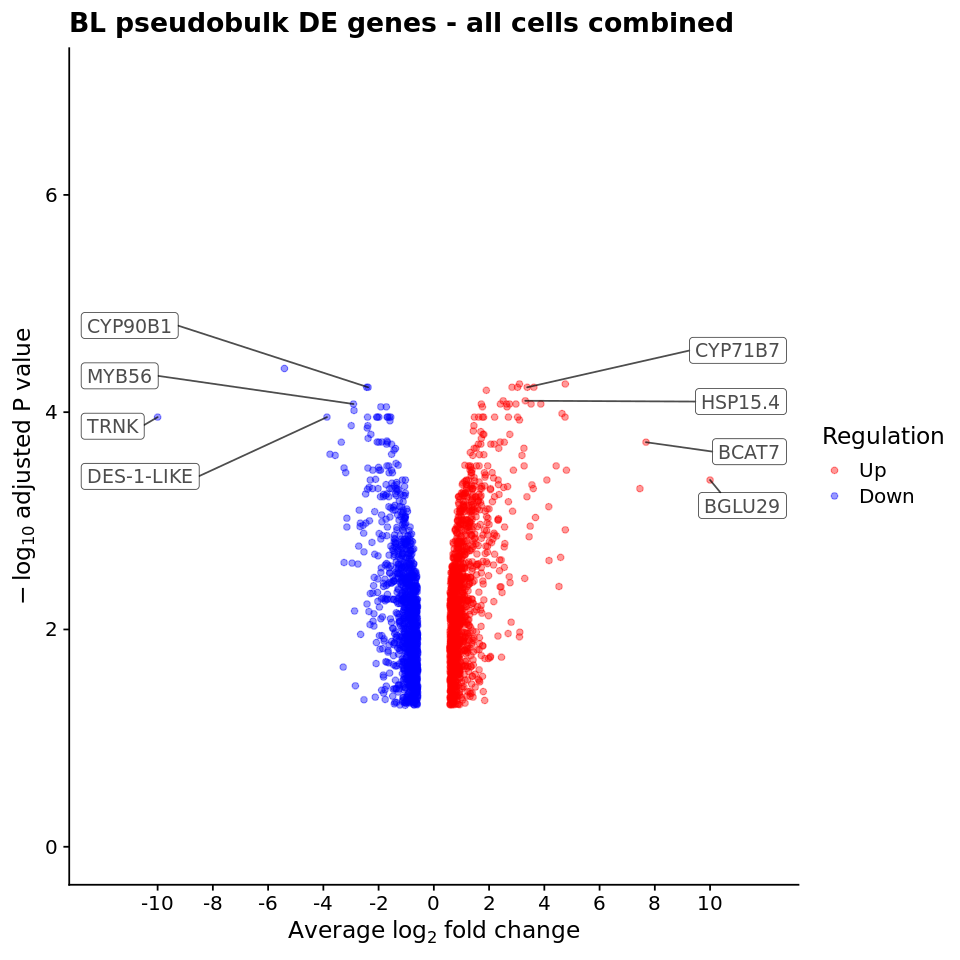

In [35]:
## Volcano plots with only DE genes

options(repr.plot.width = 8, repr.plot.height = 8)
nb_de_total_names <- sig_DE_fil

# need combo of cluster and gene 
#nb_de_total_names$sig <- nb_de_total_names$gene_id %in% nb_DE_sig$gene_id

#nb_de_total_names$known_drought <- nb_de_total_names$gene_id %in% drought_names$gene_id

# nb_de_total_names %>%
#   group_by(gene_id) %>%
#   filter(known_drought==T & sig==T) %>%
#   ungroup() %>%
#   select(gene_id) %>%
#   distinct()

nb_de_total_names <- dplyr::rename(nb_de_total_names, log2FC=logFC)

nb_de_total_names$logFDR <- -log10(nb_de_total_names$p_adj.loc)
# color up/down and facet plot 

# filter(nb_de_total, p_val_adj<=0.05) %>%
# filter(avg_logFC>=log2(1.25) | avg_logFC<=log2(3/4))

all_time_pts <- nb_de_total_names %>%
  mutate(up_dn_label = case_when(log2FC >=log2(1.25) ~ "Up",  
                                       log2FC <=log2(3/4) ~ "Down",
                                       TRUE ~ "Not DE"))
all_time_pts$up_dn_label <- factor(all_time_pts$up_dn_label, levels=c("Up", "Down", "Not DE"))


all_time_pts$sig <- all_time_pts$up_dn_label !="Not DE"
# set limits of FC and logFDR
all_time_pts_cut <- all_time_pts
# round to cutoff at 4
all_time_pts_cut$logFDR[all_time_pts_cut$logFDR>10] <- 10

# limit log2FC to 4 
all_time_pts_cut$log2FC[all_time_pts_cut$log2FC>10] <- 10
all_time_pts_cut$log2FC[all_time_pts_cut$log2FC < -10] <- -10

# # labels 
# 
# time.labs <- c("15 min", "30 min", "1 hour", "2 hour", "4 hour", "8 hour")
# names(time.labs) <- c(1, 2, 3, 4, 5, 6)

genes_w_names <- filter(all_time_pts_cut, !grepl("^AT[1-5]", Name) & sig==TRUE)

top_genes_to_label <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(10, logFDR) %>%
  top_n(2, log2FC)
top_genes_to_label2 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(10, logFDR) %>%
  top_n(2, -log2FC)

top_genes_to_label3 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(2, log2FC)
top_genes_to_label4 <- genes_w_names %>%
  group_by(cluster_id) %>%
  top_n(2, -log2FC)


# top_genes_to_label5 <- genes_w_names %>%
#   group_by(cluster) %>%
#   filter(known_drought==T) %>%
#   top_n(100, logFDR) %>%
#   top_n(2, log2FC)
# top_genes_to_label6 <- genes_w_names %>%
#   group_by(cluster) %>%
#   filter(known_drought==T) %>%
#   top_n(100, logFDR) %>%
#   top_n(2, -log2FC)
# top_genes_to_label7 <- genes_w_names %>%
#   group_by(cluster) %>%
#   filter(known_drought==T) %>%
#   top_n(2, log2FC)
# top_genes_to_label8 <- genes_w_names %>%
#   group_by(cluster) %>%
#   filter(known_drought==T) %>%
#   top_n(2, -log2FC)

# top_genes_to_label <- bind_rows(top_genes_to_label, top_genes_to_label2, top_genes_to_label3, top_genes_to_label4, top_genes_to_label5, top_genes_to_label6, top_genes_to_label7, top_genes_to_label8) %>%
#   distinct()

top_genes_to_label <- bind_rows(top_genes_to_label, top_genes_to_label2, top_genes_to_label3, top_genes_to_label4) %>%
  distinct()

up_genes_to_label <- filter(top_genes_to_label, log2FC>0)
down_genes_to_label <- filter(top_genes_to_label, log2FC<0)


p = ggplot(all_time_pts_cut, aes(log2FC, logFDR)) +
  geom_point(aes(col=up_dn_label), alpha = 0.4) +
  scale_color_manual(values=c("red", "blue", "black")) + 
  scale_x_continuous(limits=c(-12, 12), breaks = c(-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10)) + scale_y_continuous(limits=c(0, 7), breaks = c(0, 2, 4, 6)) + 
  xlab(expression(Average~log[2]~fold~change)) + 
  ylab(expression(-log[10]~adjusted~P~value)) + 
  scale_alpha(guide="none")

all_plot <- p+ geom_label_repel(data=up_genes_to_label, 
                   aes(label=Name), 
                   size = 4, 
                   nudge_x = 11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) + 
  geom_label_repel(data=down_genes_to_label, 
                   aes(label=Name), 
                   size = 4, 
                   nudge_x = -11.5, 
                   direction = "y", 
                   alpha = 0.7, box.padding = 0.5) +
  labs(color = "Regulation") + ggtitle("") + theme_minimal() + theme(plot.title = element_text(hjust = 0.5))



all_plot + ggtitle("BL pseudobulk DE genes - all cells combined") + theme_cowplot()


## Up vs down

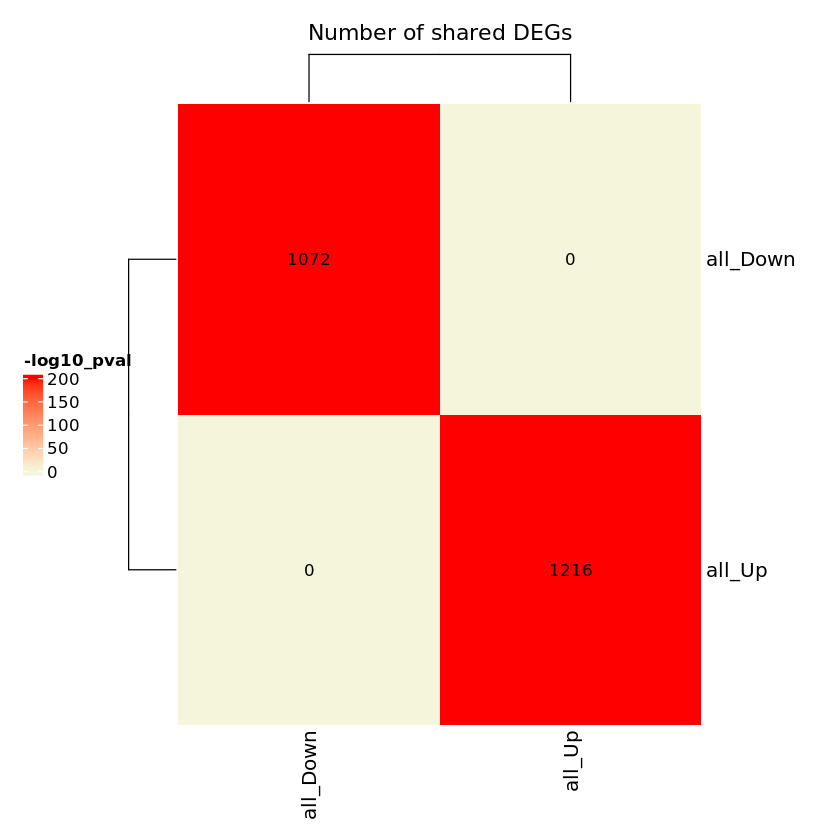

In [36]:


options(repr.plot.width = 7, repr.plot.height = 7)


markers_sel <- select(sig_DE_fil, gene, clust_up_dn)

markers_list <- split(markers_sel, f=markers_sel$clust_up_dn)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
 
## GeneOverlap  
# number of TAIR10 genes
genome_size <- 27416L   


#compare all lists
gom.self <- newGOM(markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, name = "-log10_pval", col = colorRamp2(c(0, 200), c("beige", "red")), 
                column_title = "Number of shared DEGs", cluster_rows = T,cluster_columns = T, use_raster= FALSE, show_column_names = TRUE, show_row_names = TRUE, show_row_dend = TRUE, show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(5, 5, 5, 10), "mm"), heatmap_legend_side = "left")
                        
                        
BL_up_dn_markers_list <- markers_list

In [37]:
cluster_GO <- gost(BL_up_dn_markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=8) %>%
  group_by(query) %>%
  top_n(10, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=8) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name

GO_hm <- Heatmap(spread_GO_m, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="topcenter", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 15), c("beige", "darkgreen")), 
                 cluster_rows = T, 
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE,
                 clustering_distance_columns = "pearson", 
                 clustering_distance_rows = "pearson",
                 row_names_gp = gpar(fontsize = 14), 
                column_names_gp = gpar(fontsize = 14)) 


Joining, by = "term_id"



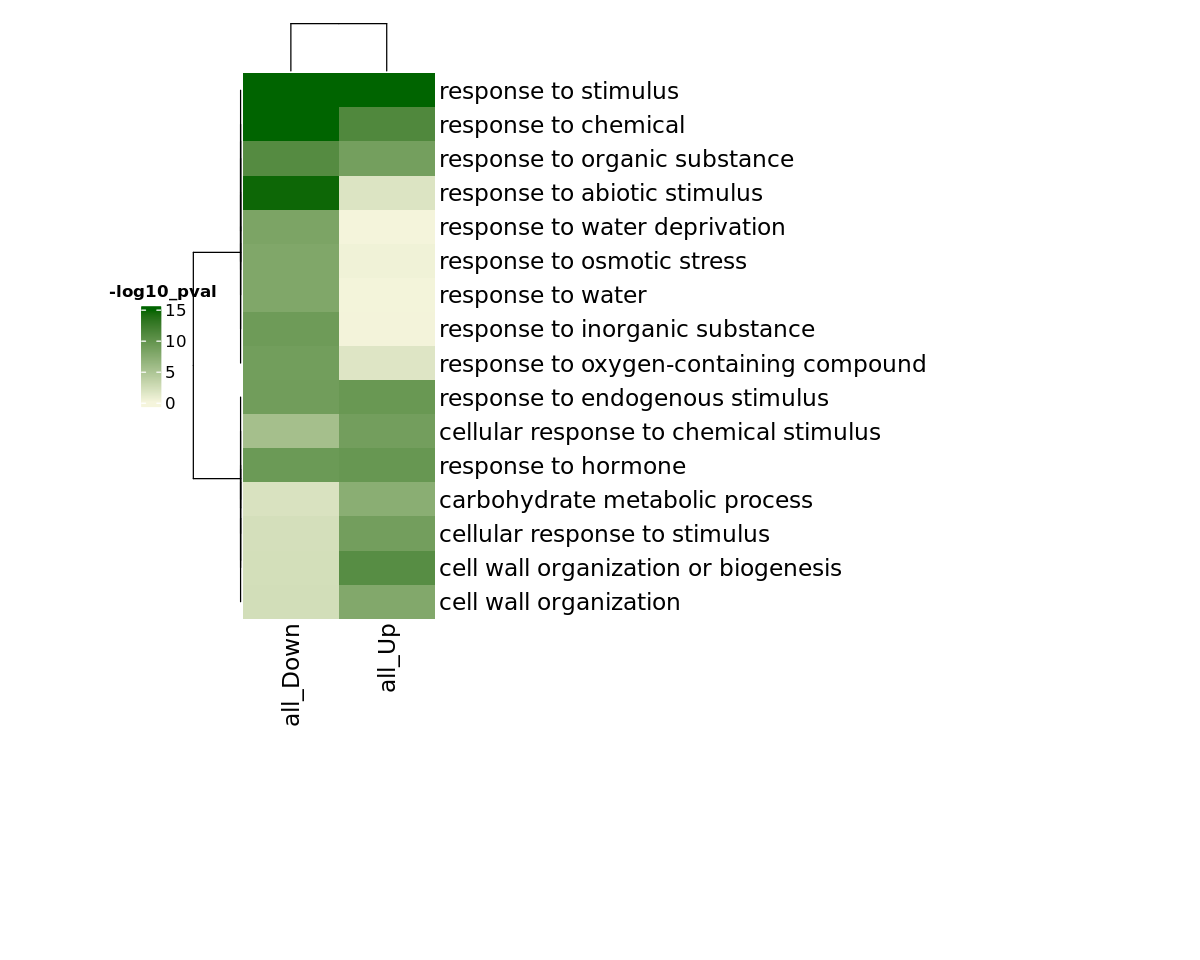

In [38]:
options(repr.plot.width = 10, repr.plot.height = 8)
# padding - bottom, left, top, right
draw(GO_hm, padding = unit(c(50, 30, 5, 100), "mm"), heatmap_legend_side = "left")

In [39]:
# subset BRZ and BL 2 hour samples only samples you want to compare

integrated.de <- subset(rc.integrated, subset = sample!="sc_1")


In [40]:
table(integrated.de$treatment, integrated.de$sample)

     
      sc_2 sc_43 sc_44 sc_45 sc_46 sc_47 sc_48 sc_49 sc_5 sc_50
  BL     0     0  6843  6336  6847  6907  6389  5638 9790     0
  BRZ 7512  8874     0     0     0     0     0     0    0  5087

In [41]:
table(integrated.de$time_trt, integrated.de$date)

             
              20191214 20200212
  0.5_hour_BL        0     6843
  1_hour_BL          0     6336
  2_hour_BL       9790    12485
  4_hour_BL          0     6907
  8_hour_BL          0     6389
  BRZ             7512    13961

## Convert to sce

In [42]:
integrated.de$all_cells <- "all" 

In [43]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample,
                              group_id = integrated.de$time_trt,
                              cluster_id = integrated.de$all_cells, 
                             date=integrated.de$date)

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [44]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 28725 70223 
metadata(1): experiment_info
assays(1): counts
rownames(28725): AT1G01010 AT1G01020 ... AT4G23310 AT4G23580
rowData names(0):
colnames(70223): AAACCCAAGAGGCCAT_3 AAACCCAAGCCTGTGC_3 ...
  TTTGTTGGTGGATACG_12 TTTGTTGTCTGAGAAA_12
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [45]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 27852 70223

In [46]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 24495 70223

In [47]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "all"

In [48]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
sc_2,7521,2176,567,1125,21803,188
sc_43,5264,2906,455,1037,38643,307
sc_44,4838,2540,406,699,41918,220
sc_45,5467,2126,323,893,30033,288
sc_46,4247,2663,523,1005,47062,173
sc_47,4177,1860,491,1184,26666,281
sc_48,4638,1517,297,1127,19396,457
sc_49,3937,1904,440,962,32055,213
sc_5,7302,1905,486,1376,22384,198
sc_50,4304,2405,443,679,36641,341


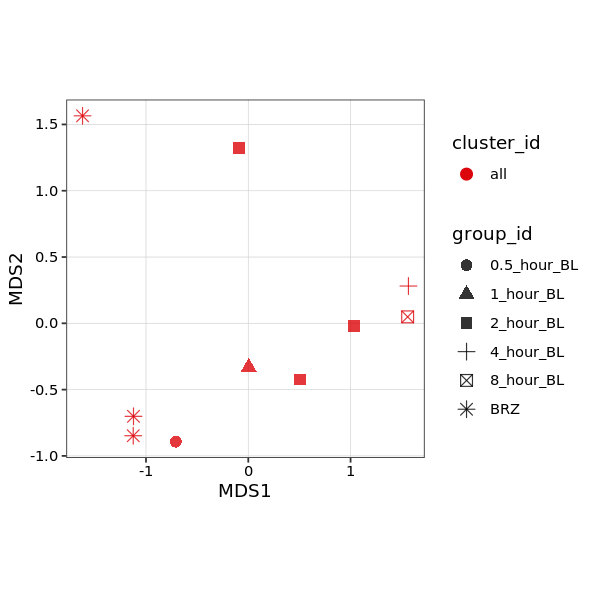

In [49]:
options(repr.plot.width=5, repr.plot.height=5)
(pb_mds <- pbMDS(pb))

ggsave("./output/BRZ_BL_all_time_pts_MDS.pdf", width=5, height=5)

In [50]:
#rename to show which experiment each sample comes from 

In [51]:
integrated.de$experiment <- integrated.de$date
integrated.de$experiment <- gsub("20191214","Pilot", integrated.de$experiment)
integrated.de$experiment <- gsub("20200212","TimeCourse", integrated.de$experiment)

In [52]:
table(integrated.de$time_trt, integrated.de$experiment)

             
              Pilot TimeCourse
  0.5_hour_BL     0       6843
  1_hour_BL       0       6336
  2_hour_BL    9790      12485
  4_hour_BL       0       6907
  8_hour_BL       0       6389
  BRZ          7512      13961

In [53]:
integrated.de$time_trt_exp <- paste0(integrated.de$time_trt, "_", integrated.de$experiment)

In [54]:
integrated.de$sample_time_trt_exp <- paste0(integrated.de$time_trt_exp, "_", integrated.de$sample)

## Convert to sce

In [55]:
integrated.de$all_cells <- "all" 

In [56]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample_time_trt_exp,
                              group_id = integrated.de$time_trt_exp,
                              cluster_id = integrated.de$all_cells, 
                             date=integrated.de$date)

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [57]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 28725 70223 
metadata(1): experiment_info
assays(1): counts
rownames(28725): AT1G01010 AT1G01020 ... AT4G23310 AT4G23580
rowData names(0):
colnames(70223): AAACCCAAGAGGCCAT_3 AAACCCAAGCCTGTGC_3 ...
  TTTGTTGGTGGATACG_12 TTTGTTGTCTGAGAAA_12
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [58]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 27852 70223

In [59]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 24495 70223

In [60]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "all"

In [61]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
0.5_hour_BL_TimeCourse_sc_44,4838,2540,406,699,41918,220
1_hour_BL_TimeCourse_sc_45,5467,2126,323,893,30033,288
2_hour_BL_Pilot_sc_5,7302,1905,486,1376,22384,198
2_hour_BL_TimeCourse_sc_46,4247,2663,523,1005,47062,173
2_hour_BL_TimeCourse_sc_49,3937,1904,440,962,32055,213
4_hour_BL_TimeCourse_sc_47,4177,1860,491,1184,26666,281
8_hour_BL_TimeCourse_sc_48,4638,1517,297,1127,19396,457
BRZ_Pilot_sc_2,7521,2176,567,1125,21803,188
BRZ_TimeCourse_sc_43,5264,2906,455,1037,38643,307
BRZ_TimeCourse_sc_50,4304,2405,443,679,36641,341


In [62]:
pb_matrix <- assay(pb)

In [63]:
pb_matrix

,0.5_hour_BL_TimeCourse_sc_44,1_hour_BL_TimeCourse_sc_45,2_hour_BL_Pilot_sc_5,2_hour_BL_TimeCourse_sc_46,2_hour_BL_TimeCourse_sc_49,4_hour_BL_TimeCourse_sc_47,8_hour_BL_TimeCourse_sc_48,BRZ_Pilot_sc_2,BRZ_TimeCourse_sc_43,BRZ_TimeCourse_sc_50
AT1G01010,4838,5467,7302,4247,3937,4177,4638,7521,5264,4304
AT1G01020,2540,2126,1905,2663,1904,1860,1517,2176,2906,2405
AT1G01030,406,323,486,523,440,491,297,567,455,443
AT1G01040,699,893,1376,1005,962,1184,1127,1125,1037,679
AT1G01050,41918,30033,22384,47062,32055,26666,19396,21803,38643,36641
AT1G01060,220,288,198,173,213,281,457,188,307,341
AT1G01070,1092,1251,885,1055,1094,804,1191,233,671,533
AT1G01080,202,196,198,175,201,222,236,186,173,130
AT1G01090,8622,10187,10119,12921,9905,11027,7862,8229,12539,7948
AT1G01100,49480,67120,38334,79140,55854,53128,43973,43079,81658,51177


In [64]:
write.csv(pb_matrix, "./output/BL_timecourse_all_cells_pseudobulk.csv")

In [65]:
library(edgeR)


Attaching package: ‘edgeR’


The following object is masked from ‘package:SingleCellExperiment’:

    cpm




In [66]:
y <- DGEList(counts=pb_matrix)

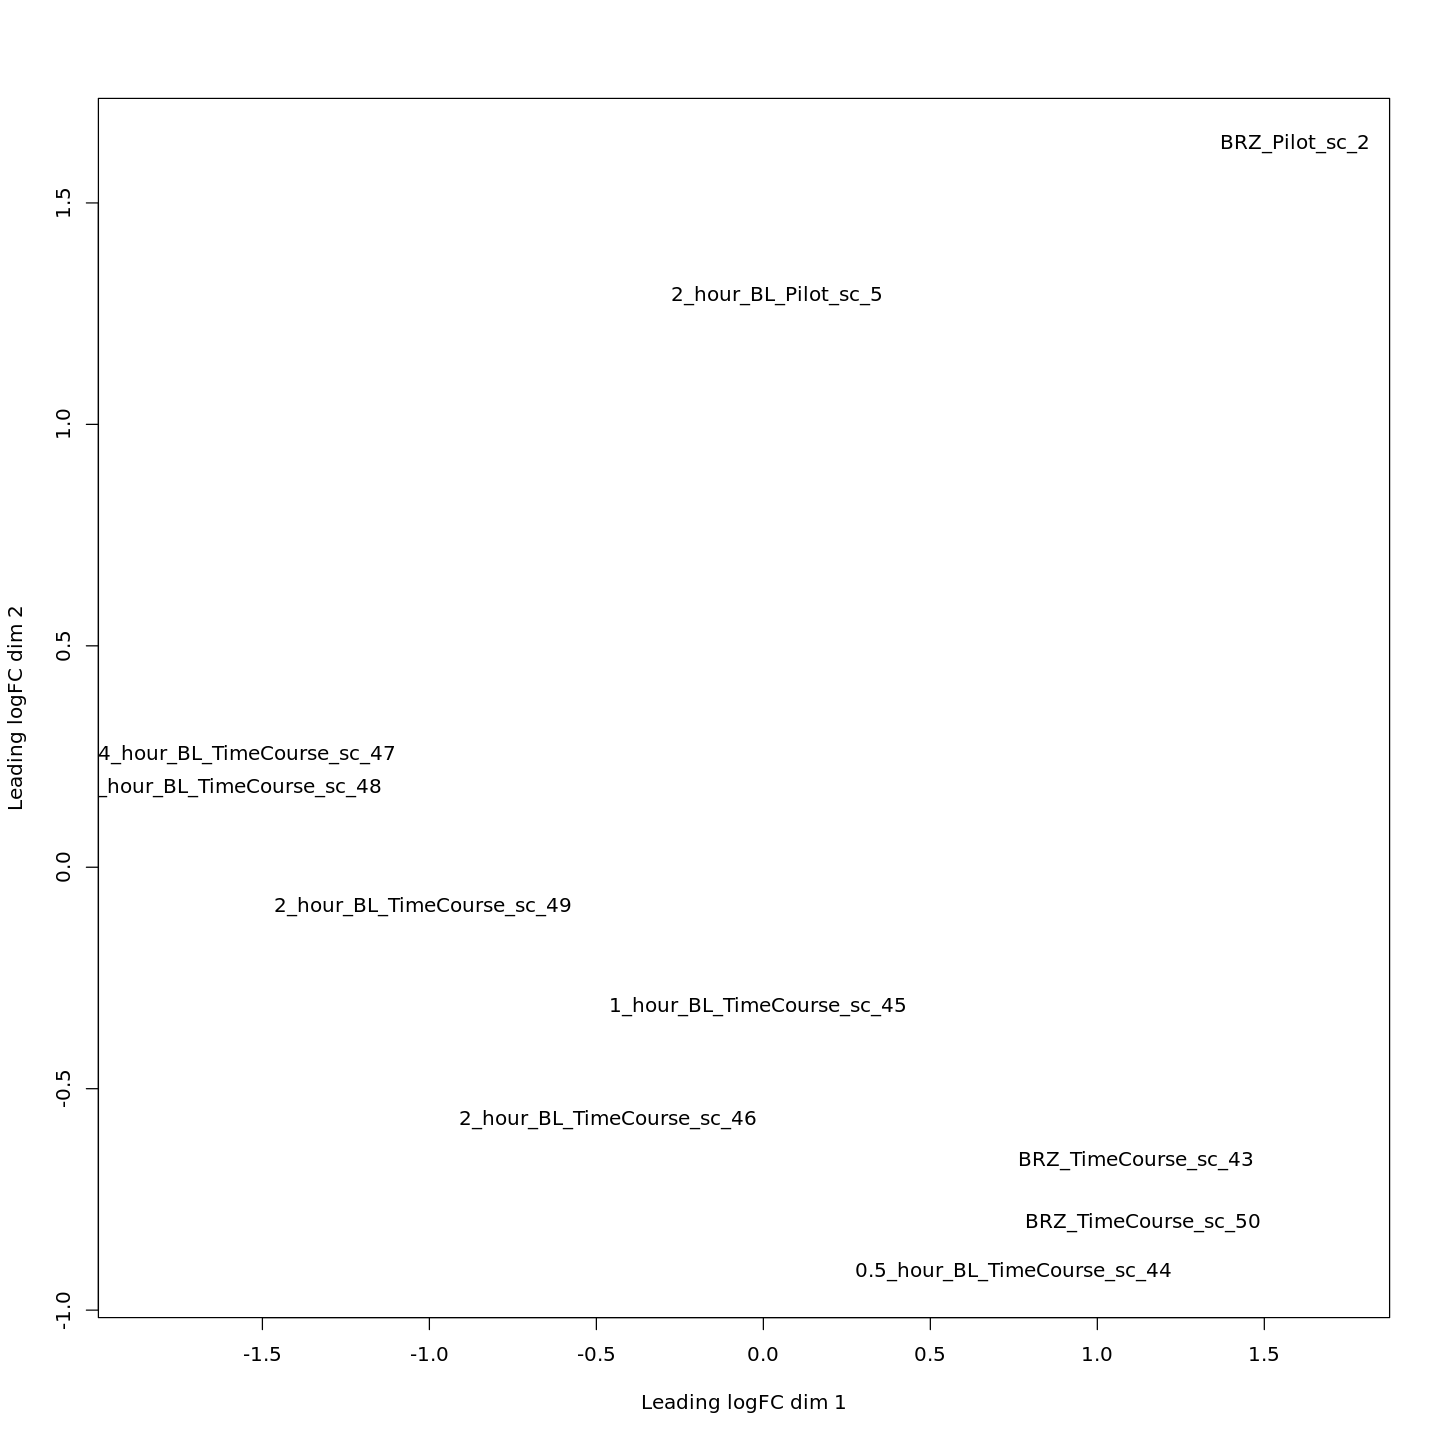

In [67]:
options(repr.plot.width=12, repr.plot.height=12)
plotMDS(y)

In [68]:
library(corrplot)

corrplot 0.92 loaded



In [69]:
M <- cor(pb_matrix, method = "pearson")

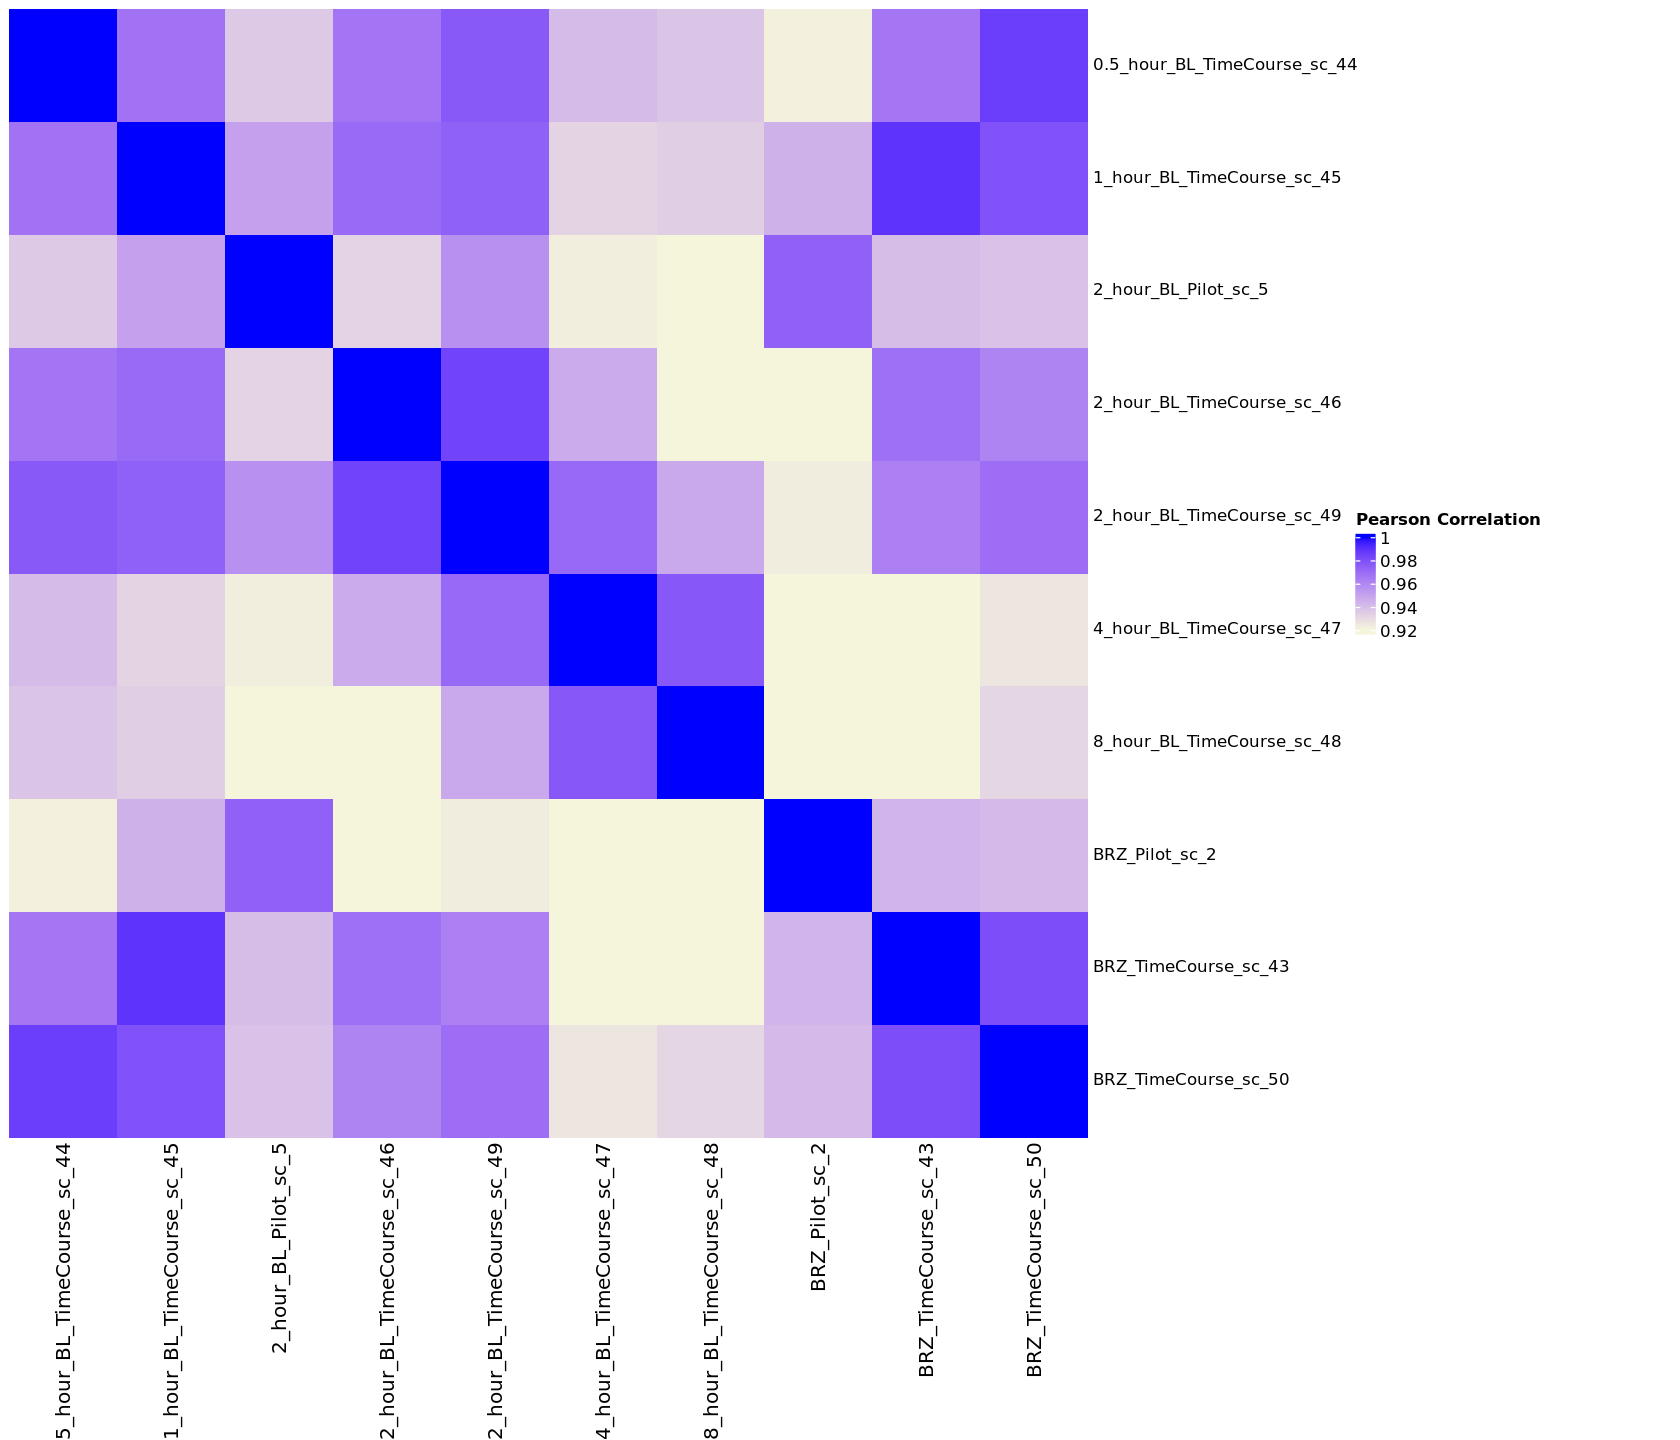

In [70]:
options(repr.plot.width=14, repr.plot.height=12)


hm <- Heatmap(M, col = colorRamp2(c(0.92, 1), c("beige", "blue")), 
                    name = "Pearson Correlation", 
                    # column_split = col_split_labels, 
                    # row_split = 4, 
                    row_names_side = "right",
                  cluster_rows = F,
                 clustering_distance_rows = "pearson",
                cluster_columns=F,
              clustering_distance_columns = "pearson",
                 row_names_gp = gpar(fontsize = 10), 
                 heatmap_legend_param = list(direction = "vertical"))




draw(hm, padding = unit(c(2, 2, 2, 35), "mm"))

#pdf("./docs/all_sample_corr_hm_regular_QS.pdf", width = 25, height = 20)


#draw(hm, padding = unit(c(30, 30, 30, 70), "mm"))


#dev.off()